# White-box Attack on CIFAR10

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
# TODO: Specify your path here
new_directory = "/content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj"
os.chdir(new_directory)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj


In [3]:
import sys
#
import torch
import torch.nn as nn

#sys.path.insert(0, '..')
# import torchattacks

In [4]:
%cd adversarial-attacks-pytorch
import torchattacks
import robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy
%cd ..

/content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj/adversarial-attacks-pytorch
/content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj


In [5]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time

In [6]:
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

#torch.manual_seed(0)

In [7]:
from torchattacks import PGD
from utils_attack import *

In [8]:
device = 'cuda' #cpu
print(torch.cuda.is_available())

True


In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Assuming a single-GPU setup
    device_properties = torch.cuda.get_device_properties(device)

    total_memory = device_properties.total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    print(f"Total GPU Memory: {total_memory / 1e9} GB")
    print(f"Allocated Memory: {allocated_memory / 1e9} GB")
    print(f"Cached Memory: {cached_memory / 1e9} GB")
else:
    print("CUDA is not available.")

Total GPU Memory: 16.935682048 GB
Allocated Memory: 0.0 GB
Cached Memory: 0.0 GB


# LOAD MLP

In [10]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'

In [11]:
torch.backends.cuda.matmul.allow_tf32 = True

In [12]:
class MLP_Wrapper(nn.Module):
    def __init__(self, architecture, resolution, num_classes, checkpoint):
        super(MLP_Wrapper, self).__init__()
        self.model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)
        self.resize = transforms.Resize((resolution, resolution))

    def forward(self, x):
        x = self.resize(x)
        x = x.flatten(1)
        x = self.model(x)
        return x

In [13]:
model_mlp = MLP_Wrapper(architecture, crop_resolution, num_classes, checkpoint)
model_mlp = model_mlp.to(device)
model_mlp.eval()

Weights already downloaded
Load_state output <All keys matched successfully>


MLP_Wrapper(
  (model): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=10, bias=True)
    (blocks): ModuleList(
      (0-11): 12 x BottleneckBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (layernorms): ModuleList(
      (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (resize): Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
)

# LOAD CNN

In [14]:
from cifar10_models.resnet import *
model_resnet = resnet18()

# Use the weights of the resnet18 model trained on CIFAR10
weights = torch.load('state_dicts/resnet18.pt')
model_resnet.load_state_dict(weights)

model_resnet = model_resnet.to(device)
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print(model_resnet.fc.weight.is_cuda)

# LOAD ViT

In [15]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00


In [16]:
import timm
model_ViT_tmp = timm.create_model("vit_tiny_patch16_224", pretrained=True)
model_ViT_tmp.head = nn.Linear(model_ViT_tmp.head.in_features, 10) # CIFAR10
checkpoint = torch.load("finetuned_models/vit_tiny_patch16_224_unfrozen_CIFAR.t7", map_location=torch.device("cpu"))
model_ViT_tmp = torch.nn.DataParallel(model_ViT_tmp)
model_ViT_tmp.load_state_dict(checkpoint['model'])
print("model loaded")
# ViT uses 224x224 pixel image
input_size = 224


#vit_tiny_patch16_224_CIFAR.t7

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

model loaded


In [17]:
class ViT_Wrapper(nn.Module):
    def __init__(self, model, input_size):
        super(ViT_Wrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = self.model(x)
        return x

In [18]:
model_ViT = ViT_Wrapper(model_ViT_tmp, input_size).to(device)
model_ViT.eval()

ViT_Wrapper(
  (model): DataParallel(
    (module): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192,

In [ ]:
print(next(model_ViT.parameters()).device)

cuda:0


# LOAD DATA

In [19]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    #transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

batch_size = 100

dataset = datasets.CIFAR10(root='./data',
                           train=False,
                           transform=transform,
                           download=True)

test_loader = DataLoader(dataset,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=0)

Files already downloaded and verified


In [20]:
#sys.path.insert(0, '..')
import robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy


In [ ]:
print('[Data loaded]')

acc_mlp_list = []
acc_cnn_list = []
acc_vit_list = []

for batch in test_loader:
    images, labels = batch
    acc_mlp = clean_accuracy(model_mlp, images.to(device), labels.to(device))
    acc_mlp_list.append(acc_mlp)

    acc_cnn = clean_accuracy(model_resnet, images.to(device), labels.to(device))
    acc_cnn_list.append(acc_cnn)

    acc_vit = clean_accuracy(model_ViT, images.to(device), labels.to(device))
    acc_vit_list.append(acc_vit)

[Data loaded]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
acc_mlp = np.array(acc_mlp_list)
acc = acc_mlp.mean()
print('[MLP loaded]')
print('MLP Acc: %2.2f %%'%(acc*100))

acc_cnn = np.array(acc_cnn_list)
acc = acc_cnn.mean()
print('[CNN loaded]')
print('CNN Acc: %2.2f %%'%(acc*100))

acc_vit = np.array(acc_vit_list)
acc = acc_vit.mean()
print('[ViT loaded]')
print('ViT Acc: %2.2f %%'%(acc*100))

[MLP loaded]
MLP Acc: 94.09 %
[CNN loaded]
CNN Acc: 93.07 %
[ViT loaded]
ViT Acc: 96.74 %


# Testing if torchattacks library works

In [ ]:
labell = 100
img = dataset[labell][0].unsqueeze(0).to(device)
labl = torch.tensor([dataset[labell][1]]).to(device)

In [ ]:
atk_cnn2 = PGD(model_ViT, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_cnn2.set_normalization_used(mean=mean, std=std)

In [ ]:
adv_img = atk_cnn2(img, labl)

prediction1 = get_pred(model_ViT, adv_img, device)

prediction2 = model_ViT(adv_img)
prediction2 = torch.argmax(prediction2, dim=1)


In [ ]:
print("prediction1:", prediction1.item())
print("prediction2:", prediction2.item())
print("true label:",labl.item())

prediction1: 5
prediction2: 5
true label: 4


In [ ]:
un_adv_img = atk_cnn2.inverse_normalize(adv_img)

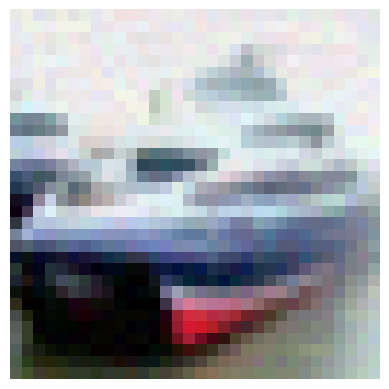

In [ ]:
# Perturbed image
image_np = un_adv_img[0].detach().permute(1, 2, 0).cpu().numpy()
plt.imshow(image_np)
plt.axis('off')
plt.show()

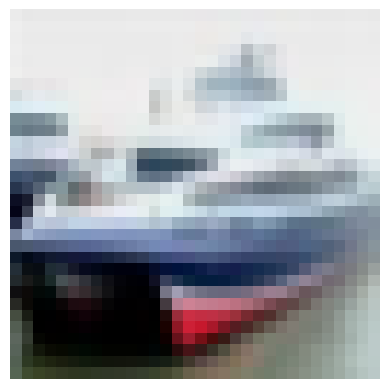

In [ ]:
# Original image
image_np = atk_cnn2.inverse_normalize(img)[0].detach().permute(1, 2, 0).cpu().numpy()
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
normalize = transforms.Normalize(mean, std)

def clamp_to_img(x):
  return torch.clamp(x, min=0., max=1.)

In [ ]:
def pga(model, images, labels, eps=2/255, lr_pga=2/225, iters=20, device="cpu"):
  # Initialize the perturbation as a variable with gradient since we will optimize over it


  r = torch.empty_like(images).uniform_(-eps, eps).to(device)
  r.requires_grad_()
  #r = images + torch.rand_like(images, requires_grad=True).to(device)

  for i in range(iters):
      # Calculate the logits for the perturbed image
      logits = model(normalize(clamp_to_img(images + r)))
      # Get the cross entropy loss
      loss = F.cross_entropy(logits, labels)
      # Calculate the gradient w.r.t. to the perturbation eta
      loss.backward()

      if i % 1 == 0:
            print(f'Iteration {i}: Loss: {loss.item()}')
      # Perform gradient ascent step
      r.data +=  lr_pga * r.grad.data
      # Clamp the perturbation to be between -eps and eps
      r.data = torch.clamp(r.data, -eps, eps)

  adv_images = clamp_to_img(images + r)
  return adv_images

# Experiments

In [21]:
def compare_adv_attacks(model1, model2, atk_model1, images, labels, device='cpu'):

    model1.eval()
    model2.eval()

    successful_adv_attacks_model1 = []
    successful_adv_attacks_model2 = []


    adv_images = atk_model1(images, labels)
    predictions = model1(adv_images)
    predictions = torch.argmax(predictions, dim=1)
    #predictions = get_pred(model1, adv_images, device)
    #predictions = predictions.cuda()

    seccessful_adv_images = adv_images[predictions != labels]
    true_labels_of_succ_adv_images = labels[predictions != labels]
    successful_adv_attacks_model1.append(seccessful_adv_images.shape[0])

    predictions = model2(seccessful_adv_images)
    predictions = torch.argmax(predictions, dim=1)
    #predictions = get_pred(model2, seccessful_adv_images, device)
    #predictions = predictions.cuda()
    seccessful_adv_images = seccessful_adv_images[predictions != true_labels_of_succ_adv_images]
    successful_adv_attacks_model2.append(seccessful_adv_images.shape[0])

    return successful_adv_attacks_model1, successful_adv_attacks_model2




# MLP vs Resnet18 experiment

In [30]:
N_exp = 10

atk_mlp = PGD(model_mlp, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_mlp.set_normalization_used(mean=mean, std=std)


l1_list_mlp = []
l2_list_mlp = []
# 100 batches
for i,batch in enumerate(test_loader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []

    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_mlp(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_resnet(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]

    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_mlp, model_resnet, atk_mlp, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_mlp.append(ll1_list)
    l2_list_mlp.append(ll2_list)

batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99


In [ ]:
# Trained on mlp Tested on resnet

In [31]:
mlp_adv = np.array(l1_list_mlp)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

cnn_adv = np.array(l2_list_mlp)
cnn_adv = np.squeeze(cnn_adv,2)
cnn_adv = cnn_adv.sum(axis=0)

cnn_adv_mean = cnn_adv.mean(axis=0)
cnn_adv_std = cnn_adv.std(axis=0)
print('cnn_adv_mean: ', cnn_adv_mean)
print('cnn_adv_std: ', cnn_adv_std)



mlp_adv_mean:  7600.4
mlp_adv_std:  12.815615474880634
cnn_adv_mean:  818.7
cnn_adv_std:  20.015244190366502


In [32]:
print("ratio: ", (cnn_adv_mean/mlp_adv_mean)*100)

ratio:  10.771801484132414


In [22]:
N_exp = 10

atk_cnn = PGD(model_resnet, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_cnn.set_normalization_used(mean=mean, std=std)


l1_list_cnn = []
l2_list_cnn = []
# 100 batches
for i,batch in enumerate(test_loader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []

    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_resnet(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_mlp(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]

    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_resnet, model_mlp, atk_cnn, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_cnn.append(ll1_list)
    l2_list_cnn.append(ll2_list)

batch: 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99


In [ ]:
# Trained on resnet Tested on mlp

In [23]:
cnn_adv = np.array(l1_list_cnn)
cnn_adv = np.squeeze(cnn_adv,2)
cnn_adv = cnn_adv.sum(axis=0)

cnn_adv_mean = cnn_adv.mean(axis=0)
cnn_adv_std = cnn_adv.std(axis=0)
print('cnn_adv_mean: ', cnn_adv_mean)
print('cnn_adv_std: ', cnn_adv_std)

mlp_adv = np.array(l2_list_cnn)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

cnn_adv_mean:  8787.3
cnn_adv_std:  5.23545604508337
mlp_adv_mean:  494.3
mlp_adv_std:  13.031116606031887


In [24]:
print("ratio: ", (mlp_adv_mean/cnn_adv_mean)*100)

ratio:  5.625163588360476


# MLP vs ViT experiment

In [25]:
N_exp = 10

atk_mlp = PGD(model_mlp, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_mlp.set_normalization_used(mean=mean, std=std)


l1_list_mlp = []
l2_list_mlp = []
# 100 batches
for i,batch in enumerate(test_loader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []

    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_mlp(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_ViT(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]


    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_mlp, model_ViT, atk_mlp, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_mlp.append(ll1_list)
    l2_list_mlp.append(ll2_list)

batch: 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99


In [ ]:
# Trained on mlp Tested on vit

In [26]:
mlp_adv = np.array(l1_list_mlp)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

vit_adv = np.array(l2_list_mlp)
vit_adv = np.squeeze(vit_adv,2)
vit_adv = vit_adv.sum(axis=0)

vit_adv_mean = vit_adv.mean(axis=0)
vit_adv_std = vit_adv.std(axis=0)
print('vit_adv_mean: ', vit_adv_mean)
print('vit_adv_std: ', vit_adv_std)

mlp_adv_mean:  7856.0
mlp_adv_std:  19.24058211177614
vit_adv_mean:  1155.1
vit_adv_std:  18.886238376129853


In [28]:
print("ratio: ", (vit_adv_mean/mlp_adv_mean)*100)

ratio:  14.703411405295313


In [ ]:
N_exp = 10

atk_vit = PGD(model_ViT, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_vit.set_normalization_used(mean=mean, std=std)


l1_list_vit = []
l2_list_vit = []
# 100 batches
for i,batch in enumerate(test_loader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []


    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_ViT(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_mlp(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]


    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_ViT, model_mlp, atk_vit, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_vit.append(ll1_list)
    l2_list_vit.append(ll2_list)

batch: 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98


In [ ]:
# Trained on vit Tested on mlp

In [ ]:
vit_adv = np.array(l1_list_vit)
vit_adv = np.squeeze(vit_adv,2)
vit_adv = vit_adv.sum(axis=0)

vit_adv_mean = vit_adv.mean(axis=0)
vit_adv_std = vit_adv.std(axis=0)
print('vit_adv_mean: ', vit_adv_mean)
print('vit_adv_std: ', vit_adv_std)

mlp_adv = np.array(l2_list_vit)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

vit_adv_mean:  9674.0
vit_adv_std:  0.0
mlp_adv_mean:  914.2
mlp_adv_std:  9.410632284814872


In [ ]:
print("ratio: ", (mlp_adv_mean/vit_adv_mean)*100)

ratio:  9.450072358900146
